# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


## Generate a `Dataset`


In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 235 files belonging to 2 classes.
Using 188 files for training.
Found 235 files belonging to 2 classes.
Using 47 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


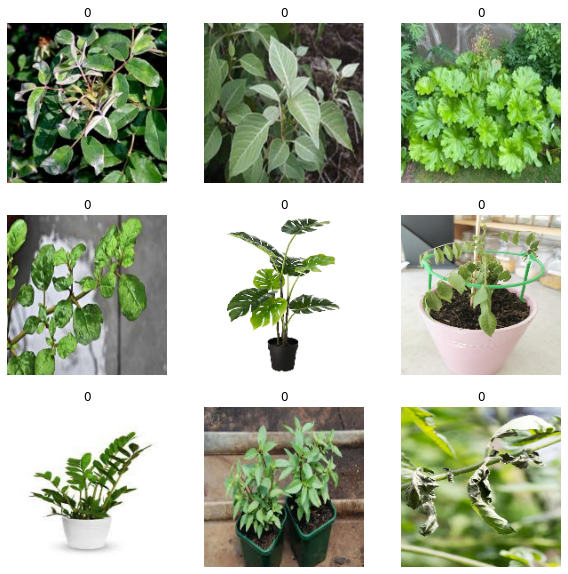

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


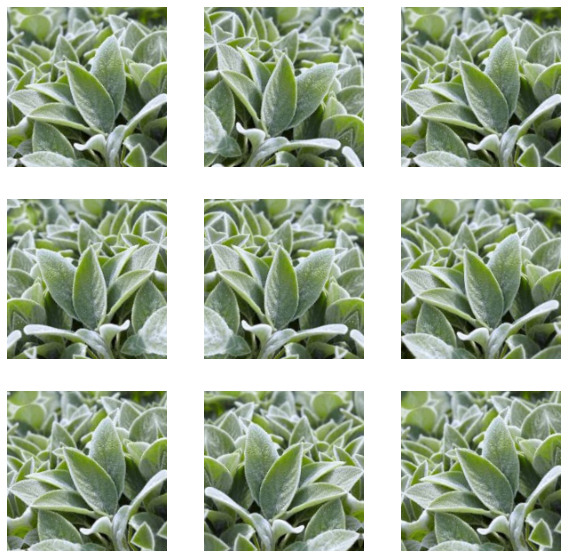

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


In [8]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Dropout(0.5)(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Train the model


In [9]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5", save_weights_only=True, verbose=1)
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-2),
    loss="binary_crossentropy",
    
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)
'''callbacks=callbacks,'''

Epoch 1/10
6/6 [==============================] - 45s 7s/step - loss: 1.1591 - accuracy: 0.6702 - val_loss: 0.7833 - val_accuracy: 0.7447
Epoch 2/10
6/6 [==============================] - 41s 7s/step - loss: 0.7581 - accuracy: 0.7500 - val_loss: 0.6191 - val_accuracy: 0.7447
Epoch 3/10
6/6 [==============================] - 49s 8s/step - loss: 0.7339 - accuracy: 0.7287 - val_loss: 5.1833 - val_accuracy: 0.7447


KeyboardInterrupt: 

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('vgg16_NP1.h5')


In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: C:\Users\utsav\AppData\Local\Temp\tmpgulakuc3\assets


KeyboardInterrupt: 

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [ ]:
img = keras.preprocessing.image.load_img(
    "abc1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent healthy plant and %.2f percent droop plant."
    % (100 * (1 - score), 100 * score)
)


In [ ]:
import splitfolders # or import splitfolders
input_folder = "Dataset/Dataset_new"
output = "Dataset" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 235 files [00:03, 64.69 files/s]


In [ ]:
import pause
from datetime import datetime
while True:
    print("Before")
    pause.until(datetime(2022, 1, 6, 20,51 ))
    print("After")


In [ ]:
from tflite_runtime.interpreter import Interpreter

interpreter = Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
from PIL import Image
import glob
i=0
for file in glob.glob("Dataset/healthy plants/*.*"):
    # im = Image.open(file)
    # rgb_im = im.convert('RGB')
    print(file)
    # rgb_im.save(file.replace("png", "jpg"), quality=100)
    i = i+1
    im1 = Image.open(file)
    a = "Dataset/"+str(i)+".png"
    im1.save(a)

Dataset/healthy plants\1627652416-Bird-of-Paradise_746d55b281d8490f984a352470e4764e.jpg
Dataset/healthy plants\41+nSE7D3PL.jpg
Dataset/healthy plants\Aglaonema-red-800x800.png
Dataset/healthy plants\aglaonemapinkbeauty_45_1.png
Dataset/healthy plants\decorative-plants-500x500.jpg
Dataset/healthy plants\detail-Aglaonema-Silverado-XL_400x400.jpg
Dataset/healthy plants\download (1).jfif
Dataset/healthy plants\download (2).jfif
Dataset/healthy plants\download (3).jfif
Dataset/healthy plants\download (4).jfif
Dataset/healthy plants\download (5).jfif
Dataset/healthy plants\download (6).jfif
Dataset/healthy plants\download (7).jfif
Dataset/healthy plants\download.jfif
Dataset/healthy plants\fejka-artificial-potted-plant-in-outdoor-monstera__0614197_pe686822_s5.webp
Dataset/healthy plants\images (1).jfif
Dataset/healthy plants\images (10).jfif
Dataset/healthy plants\images (100).jfif
Dataset/healthy plants\images (11).jfif
Dataset/healthy plants\images (12).jfif
Dataset/healthy plants\images (

In [ ]:
from PIL import Image

for i in 
im1 = Image.open(r'C:\Users\Ron\Desktop\Test\autumn.jpg')
im1.save(r'C:\Users\Ron\Desktop\Test\new_autumn.png')